# Neural Network Training and Hyperparameter Tuning

This notebook is dedicated to building a neural network model for classification purposes, applying various preprocessing techniques, training the model, and performing hyperparameter tuning to optimize its performance.

## Importing Required Libraries

In this step, we import the necessary libraries for data manipulation, preprocessing, and model building.

In [54]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import itertools

## Data Loading and Initial Cleanup
We load the dataset and drop unnecessary columns that do not contribute to our model.

In [55]:
tr = pd.read_csv("matches_final.csv", index_col=False)
columns_to_drop = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot',
                   'goal_diff', 'day', 'pk', 'pkatt', 'fk',
                   'referee', 'dist','points', 'season_winner', 'hour', 'result_encoded', 'day_code']
tr = tr.drop(columns=columns_to_drop)

## Identifying Numerical and Categorical Columns
We identify numerical and categorical columns for further processing.

In [ ]:
num_cols = tr.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['season'])
num_cols = num_cols.tolist()
cat_cols = tr.select_dtypes(exclude=np.number).columns
cat_cols = cat_cols.drop(['result', 'date'])

## Handling Missing Values and Data Types
We remove rows with missing values and standardize column names.

In [56]:
tr.dropna(inplace=True)
tr.columns = tr.columns.str.strip()
tr = tr[tr.columns.tolist()[1:]]

## Consolidating Rare Categories
We consolidate categories in the time column to ensure all categories are sufficiently represented.

In [57]:
tr['time'] = tr['time'].astype('category')
value_counts = tr.time.value_counts()
to_replace = value_counts[value_counts < 102].index
tr['time'] = tr['time'].replace(to_replace, 'Altro')

cat_cols = tr.select_dtypes(exclude=np.number).columns.tolist()
num_cols = tr.select_dtypes(include=np.number).columns.tolist()
predictors = num_cols + cat_cols

## Preparing Data for Training
We prepare the feature matrix X and target vector y.

In [59]:
X = tr.drop('result', axis=1)
y = tr['result']

## Encoding Categorical Variables
We encode categorical variables into a format suitable for the model.

In [60]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

X_categorical_encoded = pd.get_dummies(X[categorical_cols], columns=categorical_cols)

scaler = StandardScaler()
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols)

## Combining Encoded and Scaled Features
We combine the encoded categorical features with the scaled numerical features to create the final feature set.

In [63]:
X_categorical_encoded = X_categorical_encoded.reset_index(drop=True)
X_numerical_scaled = X_numerical_scaled.reset_index(drop=True)
X_final = pd.concat([X_categorical_encoded, X_numerical_scaled], axis=1)

## Encoding the Target Variable
We encode the target variable for use in model training.

In [65]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## Splitting the Data into Training and Test Sets
We create a test set and split the data into training and validation sets.

In [66]:
test_x = X_final.tail(761)
test_y = y_encoded[-761:]
test_x['result'] = test_y
test_x.to_csv("test_set.csv", index=False)

X_final = X_final.iloc[:-761]
y_encoded = y_encoded[:-761]


X_train, X_val, y_train, y_val = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

## Building the Initial Neural Network Model
We define and compile our initial neural network model.

In [70]:
initial_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

initial_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Training the Initial Model
We train the initial model and evaluate its performance on validation data.

In [71]:
initial_history = initial_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5205 - loss: 0.9939 - val_accuracy: 0.6250 - val_loss: 0.8575
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6343 - loss: 0.8161 - val_accuracy: 0.6316 - val_loss: 0.8389
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6499 - loss: 0.7670 - val_accuracy: 0.6069 - val_loss: 0.8471
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6905 - loss: 0.7015 - val_accuracy: 0.6020 - val_loss: 0.8532
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7007 - loss: 0.7054 - val_accuracy: 0.6069 - val_loss: 0.8659
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7080 - loss: 0.6643 - val_accuracy: 0.5938 - val_loss: 0.8794
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7179 - loss: 0.6436 - val_accuracy: 0.5855 - val_loss: 0.8944
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7520 - loss: 0.6104 - val_accuracy: 0.5789 - val_loss:

## Plotting Training History
We visualize the training and validation loss and accuracy over epochs.

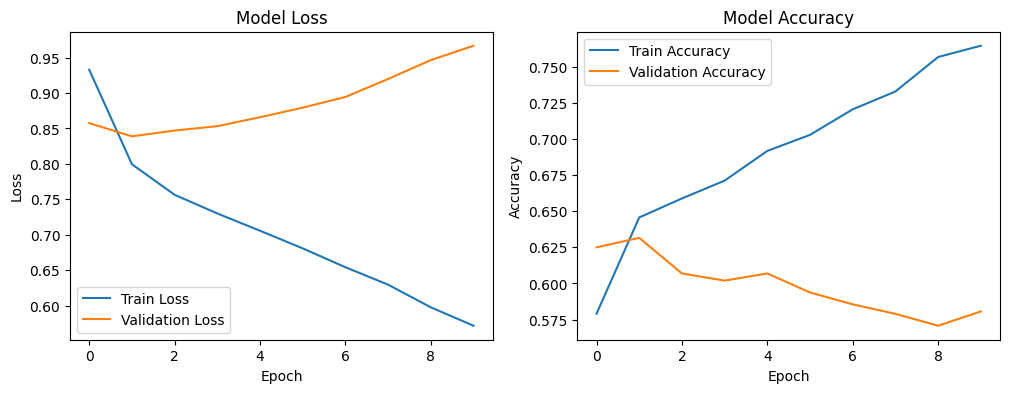

In [72]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(initial_history.history['loss'], label='Train Loss')
plt.plot(initial_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(initial_history.history['accuracy'], label='Train Accuracy')
plt.plot(initial_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Defining a Function for Model Creation
We define a function to create a neural network model with specified parameters for hyperparameter tuning.

In [73]:
def create_network(input_dim, neurons_1layer, neurons_2layer, activation_function):
    model = keras.Sequential([
        layers.Dense(neurons_1layer, activation=activation_function, input_shape=(input_dim,)),
        layers.Dense(neurons_2layer, activation=activation_function),
        layers.Dropout(0.1),
        layers.Dense(3, activation="softmax")
    ])
    return model

## Hyperparameter Grid Search
We define the grid of hyperparameters to explore and prepare for training models with each combination.

In [74]:
GRID_SEARCH = {
    "learning_rate": [1e-3],
    "epochs": [5, 6, 7, 8, 9, 10],
    "neurons_1layer": [50, 55],
    "neurons_2layer": [30, 50],
    "activation_functions": ['relu', 'sigmoid', 'tanh'],
    "batch_size": [200]
}

grid_combinations = list(itertools.product(
    GRID_SEARCH['learning_rate'],
    GRID_SEARCH['epochs'],
    GRID_SEARCH['neurons_1layer'],
    GRID_SEARCH['neurons_2layer'],
    GRID_SEARCH['activation_functions'],
    GRID_SEARCH['batch_size']
))

## Finding the Best Hyperparameters
We loop through each combination of hyperparameters, train the model, and track the best parameters based on validation loss.

In [77]:
best_params = None
best_val_loss = np.inf

for combination in grid_combinations:
    learning_rate, epochs, neurons_1layer, neurons_2layer, activation_function, batch_size = combination

    print(f"Testing combination: lr={learning_rate}, epochs={epochs}, neurons_1layer={neurons_1layer}, neurons_2layer={neurons_2layer}, activation={activation_function}, batch_size={batch_size}")

    # Create the model with current hyperparameters
    model = create_network(X_train.shape[1], neurons_1layer, neurons_2layer, activation_function)

    # Compile the model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Get the validation loss of the last epoch
    final_val_loss = history.history['val_loss'][-1]

    # Print the validation loss for the current combination
    print(f"Validation loss: {final_val_loss}")

    # Update the best parameters if current combination has the lowest validation loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = {
            "learning_rate": learning_rate,
            "epochs": epochs,
            "neurons_1layer": neurons_1layer,
            "neurons_2layer": neurons_2layer,
            "activation_function": activation_function,
            "batch_size": batch_size
        }


Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8732813000679016
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9973570108413696
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8484892845153809
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8570876717567444
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.974012553691864
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8463320732116699
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8540071249008179
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9869096875190735
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8341590762138367
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8675279021263123
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9887560606002808
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8446463346481323
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8567525744438171
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9586665630340576
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8379600644111633
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8467132449150085
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9500990509986877
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8504094481468201
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.850207507610321
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.970625102519989
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8350380659103394
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8450685739517212
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9339700937271118
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8343130350112915
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8605399131774902
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9534234404563904
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8481332659721375
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8432847857475281
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9381502866744995
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8454135060310364
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8563904762268066
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9497973918914795
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8466172218322754
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8542721271514893
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9580633044242859
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8419305086135864
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.843622624874115
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9588881134986877
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8558520078659058
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8384988307952881
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.911354660987854
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8494038581848145
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8565714955329895
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9149395823478699
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.845107913017273
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8438339233398438
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9148666858673096
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8573284149169922
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8512204885482788
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9235466122627258
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8539402484893799
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8542184233665466
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9574771523475647
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8507118225097656
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8448259234428406
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9177988767623901
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8592501282691956
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8513528108596802
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9115691184997559
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8664562702178955
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8459261655807495
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.900722324848175
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8594486117362976
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8338626027107239
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8963239789009094
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8425582051277161
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8481210470199585
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9113079905509949
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8486738801002502
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8569343090057373
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9140976071357727
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8567977547645569


## Displaying the Best Hyperparameters
We print the best hyperparameters found during the grid search.

In [78]:
print("Best hyperparameters found:")
print(best_params)
print(f"Best validation loss: {best_val_loss}")

Best hyperparameters found:
{'learning_rate': 0.001, 'epochs': 10, 'neurons_1layer': 50, 'neurons_2layer': 50, 'activation_function': 'relu', 'batch_size': 200}
Best validation loss: 0.8338626027107239


## Building and Training the Best Model
We create a final model using the best hyperparameters and train it.

In [89]:
best_params = {'learning_rate': 0.001, 'epochs': 10, 'neurons_1layer': 50, 'neurons_2layer': 50, 'activation_function': 'relu', 'batch_size': 200}

best_model = create_network(
    X_train.shape[1],
    best_params["neurons_1layer"],
    best_params["neurons_2layer"],
    best_params["activation_function"]
)

best_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
    metrics=['accuracy']
)

best_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    verbose=1  # Show progress for the final training
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3311 - loss: 1.1383 - val_accuracy: 0.5592 - val_loss: 1.0054
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5491 - loss: 0.9893 - val_accuracy: 0.5888 - val_loss: 0.9384
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5859 - loss: 0.9292 - val_accuracy: 0.5905 - val_loss: 0.9018
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6078 - loss: 0.8784 - val_accuracy: 0.6053 - val_loss: 0.8750
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6402 - loss: 0.8267 - val_accuracy: 0.6118 - val_loss: 0.8579
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6498 - loss: 0.8125 - val_accuracy: 0.6250 - val_loss: 0.8512
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6441 - loss: 0.7937 - val_accuracy: 0.6168 - val_loss: 0.8430
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6692 - loss: 0.7556 - val_accuracy: 0.6201 - val_los

## Evaluating the Best Model
We evaluate the model's performance on the validation set.

In [90]:
final_val_loss = best_history.history['val_loss'][-1]
final_val_accuracy = best_history.history['val_accuracy'][-1]

print(f"Final validation loss with best hyperparameters: {final_val_loss}")
print(f"Final validation accuracy with best hyperparameters: {final_val_accuracy}")

Final validation loss with best hyperparameters: 0.8528168201446533
Final validation accuracy with best hyperparameters: 0.6266447305679321


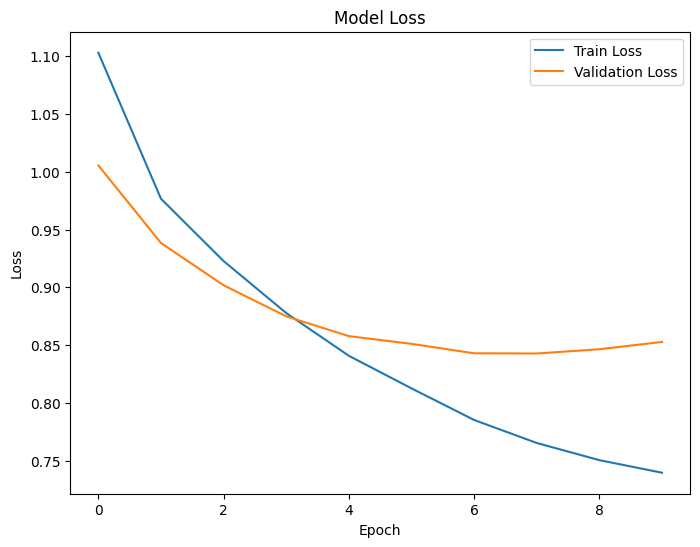

In [92]:
plt.figure(figsize=(8, 6))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
best_model.save("best_model.h5")